# Importing Libraries

In [66]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [67]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Data

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


# Reading Text File

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [ l.split('\t') for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
# Read the .txt file into a list of sentences
with open("Urdu-Eng.txt", encoding='utf-8') as f:
    sentences = f.readlines()

# Split the sentences into train, test, and validation sets
train_data, test_data= train_test_split(sentences, test_size=0.2, random_state=42)

In [7]:
train_data

['1954 جون - ہوائی سروے میں 100،000 افراد کی آبادی والی متعدد پہلے دریافت کی گئی پہاڑی وادیوں کا انکشاف ہوا ہے۔\t1954 June - Aerial survey reveals several previously undiscovered highland valleys inhabited by up to 100,000 people.\n',
 'لہذا میں نہیں جانتا کہ کسی مخبر ریاست کے بارے میں بات کرنا ٹھیک ہے۔\tI do not therefore think it is fair to talk about an informer state.\n',
 'آج کا دن سچ ہے اور آئندہ بھی ایسا ہی ہوتا رہے گا۔\tThat is true today and it will continue to be so in future.\n',
 'نوٹ: وین گانڈی نے کہا کہ وہ شروعاتی لائن اپ کے ساتھ ٹنکر جاری رکھے گا جب تک کہ وہ مرکب کے ساتھ "آرام دہ" محسوس نہ کرے۔\tNotes: Van Gundy said he\'d continue to tinker with the starting lineup until he feels "comfortable" with a combination.\n',
 'میں بھی مسٹر لیگلائس کوسٹا کا ذکر کرنا چاہتا ہوں ، جنہوں نے بڑی پیشہ ورانہ مہارت کے ساتھ اس اقدام کی رہنمائی کی۔\tI too would like to mention Mr LĂŠglise-Costa, who led this initiative with great professionalism.\n',
 'غُصہ پر قابو پانا سب سے مشکل کام ہے 

# Making Pairs of Urdu and English

In [8]:
lines = open('Urdu-Eng.txt', encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
pairs = [l.split('\t') for l in lines]


In [9]:
pairs

[['لاس اینجلس نے سیزن شروع کرنے کے لئے سیدھے رات اور اپنے پہلے 14 میں سے 13 کھیل کھوئے ہیں۔',
  'Los Angeles has lost night straight and 13 of its first 14 games to start the season.'],
 ['آنکھ کا اندھا نام نین سکھ',
  "Opposite qualities of meaning of person's name"],
 ['کھسیانی بلی کھمبا نوچے', 'To show anger after getting embarrassed'],
 ['چوری کا مال موری میں', 'Money earned the wrong way will be taken away'],
 ['چھوٹا منہ بڑی بات', 'To talk big without having a big position'],
 ['جتنے منہ اتنی باتیں', 'More mouths will have more talks'],
 ['بہتی گنگا میں ہاتھ دھونا', 'To use the available opportunity'],
 ['مان نہ مان میں تیرا مہمان', 'Getting involved without having'],
 ['دور کے ڈھول سُہانے', 'The grass is always greener on the other side'],
 ['گنگا گائے گنگا داس جمنا گائے جمنا داس', 'A person of no principles'],
 ['گھر کا بھیدی لنکا ڈھائے', 'Division is main reason for the damage'],
 ['ہاتھ کنگن کو آرسی کیا', 'Evidence does not need proof'],
 ['دھوبی کا کتا نہ گھر کا نہ گھاٹ کا

In [10]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH
        #p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Preparing the Final Data

In [41]:
# Define the reference and candidate sentences
reference = "جتنے منہ اتنی باتیں"
candidate = "More mouths will have more talks"

In [11]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('Urdu', 'Eng', False)
print(random.choice(pairs))

Reading lines...
Read 100000 sentence pairs
Trimmed to 26341 sentence pairs
Counting words...
Counted words:
Urdu 17408
Eng 24971
['جنوب مغربی ایئر لائنز 2.19٪ 3۔', 'Southwest Airlines 2.19% 3.']


In [12]:
output_lang.word2count

{'Opposite': 4,
 'qualities': 2,
 'of': 2366,
 'meaning': 4,
 "person's": 4,
 'name': 44,
 'To': 948,
 'show': 26,
 'anger': 7,
 'after': 66,
 'getting': 16,
 'embarrassed': 6,
 'Money': 60,
 'earned': 5,
 'the': 4614,
 'wrong': 28,
 'way': 88,
 'will': 526,
 'be': 836,
 'taken': 35,
 'away': 35,
 'talk': 27,
 'big': 49,
 'without': 92,
 'having': 13,
 'a': 2788,
 'position': 11,
 'More': 60,
 'mouths': 2,
 'have': 645,
 'more': 210,
 'talks': 16,
 'use': 33,
 'available': 14,
 'opportunity': 14,
 'Getting': 4,
 'involved': 8,
 'The': 1451,
 'grass': 10,
 'is': 3643,
 'always': 141,
 'greener': 6,
 'on': 645,
 'other': 85,
 'side': 21,
 'A': 895,
 'person': 22,
 'no': 487,
 'principles': 5,
 'Division': 3,
 'main': 10,
 'reason': 26,
 'for': 724,
 'damage': 6,
 'Evidence': 5,
 'does': 143,
 'not': 1084,
 'need': 115,
 'proof': 10,
 'Sour': 2,
 'grapes': 6,
 'to': 2135,
 'it': 424,
 'than': 336,
 'meets': 10,
 'eye': 36,
 'poor': 38,
 'worker': 3,
 'blames': 2,
 'his': 218,
 'tools': 3,

In [13]:
pairs

[['آنکھ کا اندھا نام نین سکھ',
  "Opposite qualities of meaning of person's name"],
 ['کھسیانی بلی کھمبا نوچے', 'To show anger after getting embarrassed'],
 ['چوری کا مال موری میں', 'Money earned the wrong way will be taken away'],
 ['چھوٹا منہ بڑی بات', 'To talk big without having a big position'],
 ['جتنے منہ اتنی باتیں', 'More mouths will have more talks'],
 ['بہتی گنگا میں ہاتھ دھونا', 'To use the available opportunity'],
 ['مان نہ مان میں تیرا مہمان', 'Getting involved without having'],
 ['دور کے ڈھول سُہانے', 'The grass is always greener on the other side'],
 ['گنگا گائے گنگا داس جمنا گائے جمنا داس', 'A person of no principles'],
 ['گھر کا بھیدی لنکا ڈھائے', 'Division is main reason for the damage'],
 ['ہاتھ کنگن کو آرسی کیا', 'Evidence does not need proof'],
 ['انگور کھٹے ہیں', 'Sour grapes'],
 ['دال میں کالا', 'More to it than meets the eye'],
 ['ناچ نہ جانے آنگھن ٹیڑھا', 'A poor worker blames his tools'],
 ['جلے پر نمک چھڑکنا', "Rubbing salt on one's wound"],
 ['آگے کنواں 

# The Seq2Seq Model

## Encoder 

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Decoder

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Attention Decoder

In [16]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Training
Preparing Training Data

In [17]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Model Training

In [58]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [19]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Negative Log Likelihood Loss

In [76]:
def trainIters(encoder, decoder, n_iters, print_every=500, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [77]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Model Evaluation

In [22]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [61]:
def evaluateRandomly(encoder, decoder, n=100):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

0m 27s (- 4m 6s) (100 10%) 35.1512
0m 54s (- 3m 37s) (200 20%) 29.9849
1m 23s (- 3m 15s) (300 30%) 34.2334
1m 55s (- 2m 53s) (400 40%) 37.0893
2m 27s (- 2m 27s) (500 50%) 35.5046
2m 57s (- 1m 58s) (600 60%) 32.6718
3m 30s (- 1m 30s) (700 70%) 37.2379
4m 1s (- 1m 0s) (800 80%) 35.7237
4m 32s (- 0m 30s) (900 90%) 33.8802
5m 4s (- 0m 0s) (1000 100%) 35.7506


<Figure size 640x480 with 0 Axes>

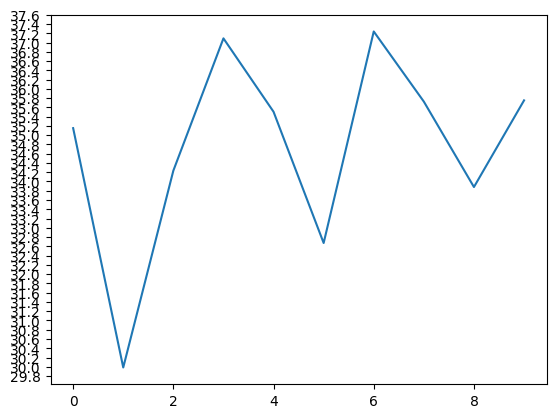

In [75]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 1000, print_every=100)

In [78]:
evaluateRandomly(encoder1, attn_decoder1)

> بُرائی آہستہ آہستہ جڑ پکڑتی ہے ۔
= No one become thoroughly bad all at once.
< A is a <EOS>

> پت گنواۓ آدمی کیا ؟
= Honour is lost, all is lost.
< A is a <EOS>

> igc اپنے اختیارات کی حدود کو پہنچا ہے۔
= The IGC has reached the limits of its powers.
< A is a <EOS>

> کر بھلا ہو بھلا ۔
= One good thern deservs another.
< A a a <EOS>

> کامیابی انسان کے بس میں نہیں ۔
= Success cannot be commanded.
< A a a <EOS>

> غزل ل ل ل ل ل ( غ ۔
= ØºØ²Ù„ Ù„ Ù„ Ù„ Ù„ Ù„ (Øº.
< A a a <EOS>

> تصویروں میں: 9/11 کی نئی تصاویر جاری کی گئیں
= In pictures: New 9/11 photos released
< A a a <EOS>

> ناپسندیدہ کام کرنا ۔
= To swall the bitter pill.
< A a <EOS>

> امریکہ نے 2009 میں 52 افراد کو پھانسی دی۔
= The United States executed 52 people in 2009.
< A is a <EOS>

> بھیک کے ٹکڑے بازار میں ڈکار ۔
= He fattens on the bread of charity.
< A a a <EOS>

> یہ واقعی اعلی معیار کی مصنوعات ہے۔
= It's really high quality products.
< A is a <EOS>

> جو ہونا تھا سو ہو چکا ! ۔
= What is done is done.
< A a a <EOS>

>

In [80]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "فطرتی  جادو")
plt.imshow(attentions.numpy())

input = جمہوریہ پسندوں نے نہیں کیا۔
output = scrutiny. scrutiny. Nuclear Guandique UNICEF then-No. then-No. Dorgan pretty. unconstitutional


C:\Users\Saad Munir\AppData\Local\Temp\ipykernel_12176\1649151038.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Saad Munir\AppData\Local\Temp\ipykernel_12176\1649151038.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


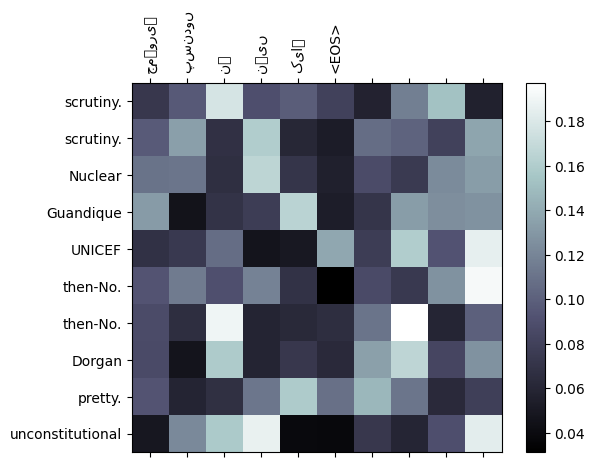

In [73]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

real_appn = "جمہوریہ پسندوں نے نہیں کیا۔"
evaluateAndShowAttention(real_appn)

reference = real_appn
candidate = output_words

# Bleu Score

In [74]:
from nltk.translate.bleu_score import sentence_bleu

In [42]:
# Calculate the Blue score
bleu_score = sentence_bleu([reference], candidate)

# Print the Blue score
print(bleu_score)


1.0080942617254966e-231
